# Analysis of Definition Evaluations

This notebook contains an analysis of the definition evals for the DRAGON-AI paper.



In [1]:
import pandas as pd

In [2]:
TEST_DEF = "Rolled oats which are cooked"

## Load evaluations into a data frame

The notebook CollectDefinitionEvaluations is responsible for downloading the evals from google sheets, adding
anonymized evaluator IDs and saving in [definitions-sheets/combined.csv](definitions-sheets/combined.csv)

In [3]:
eval_df = pd.read_csv("definitions-sheets/combined.csv")
len(eval_df["evaluator"].unique())

24

Let's break things down by ontology and evaluator

In [4]:
eval_df.groupby(["ontology", "evaluator"]).size().reset_index(name='size')

,ontology,evaluator,size
0,cl,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,435
1,cl,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,435
2,cl,6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2...,36
3,cl,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,78
4,cl,aeefbb670b0875997e7748e0f26be80a7d859410202123...,54
5,cl,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,173
6,cl,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,432
7,cl,e66016570cfafca08140913fe701f02954a11fde7f8660...,102
8,cl,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,145
9,cl,f0aab69e9fe272996e87dea1f5dfa9c48d507fbb4ffa99...,27


In [5]:
eval_df.groupby(["ontology"]).size().reset_index(name='size')

,ontology,size
0,cl,1917
1,envo,1151
2,foodon,1223
3,go,917
4,hp,355
5,mondo,472
6,mp,265
7,oba,236
8,uberon,471


## Loading definition sources

The original evaluation forms were blinded to the source of each definition. Here we do a join of the file [definitions-sheets/key.tsv](definitions-sheets/key.tsv) which has the original sources.

We also change the original obscure nomenclature for the methods (see paper for details)

Note pandas makes duplicate columns appended with `_x` which we later get rid of.

In [6]:
src_df = pd.read_csv("definitions-sheets/combined-definitions.csv")
src_df

,masked_id,label,ontology,definition,model_name,method
0,PignutHickoryNut,pignut hickory nut,foodon,A caryopsis fruit of a pignut hickory tree (Ca...,gpt-3.5-turbo,RAG+background
1,GreekYogurt,greek yogurt,foodon,Greek yogurt is a type of yogurt that is made ...,gpt-3.5-turbo,RAG+background
2,TurkeyMeat_ground_sauteed_,"turkey meat (ground, sauteed)",foodon,Ground sautéed turkey meat is a specific type ...,gpt-3.5-turbo,RAG+background
3,Raw,raw,foodon,NaN,gpt-3.5-turbo,RAG+background
4,SpeltFoodProduct,spelt food product,foodon,NaN,gpt-3.5-turbo,RAG+background
...,...,...,...,...,...,...
3335,DrySoilAlbedo,dry soil albedo,envo,Soil albedo that specifically focuses on the r...,gpt-3.5-turbo,RAG+background
3336,PediatricIntensiveCareUnitFacility,pediatric intensive care unit facility,envo,A specialized healthcare facility that provide...,gpt-3.5-turbo,RAG+background
3337,NestOfAlligator,nest of alligator,envo,A specific physical structure or location wher...,gpt-3.5-turbo,RAG+background
3338,ConcentrationOfCarbon13AtomInSeaWater,concentration of carbon-13 atom in sea water,envo,The concentration of carbon-13 atom when measu...,gpt-3.5-turbo,RAG+background


In [7]:
src_df.groupby(["method"]).size().reset_index(name='size')


,method,size
0,RAG,1506
1,RAG+background,770
2,RAG+background+github,100
3,RAG+devdocs,50
4,RAG+github,420
5,curator,494


## Merge evaluation and definition sources

The original evaluations were blinded as to definition sources (method, model/human). Here we merge these together so we can score the methods.

In [8]:

df = pd.merge(eval_df, src_df, on=['label', 'definition'])

for k in ["score", "accuracy", "internal_consistency"]:
    df[k] = pd.to_numeric(df[k], errors='coerce')
len(df)
df

,ontology_x,label,definition,internal_id,accuracy,internal_consistency,score,confidence,notes,is_a,relationships,evaluator,Unnamed: 12,masked_id,ontology_y,model_name,method
0,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,NaN,5.0,3,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
1,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,NaN,4.0,4,The 'that' is not well defined.,Ciliated Cell,"{'predicate': 'PartOf', 'target': 'Respiratory...",ef07b359570add31929a5422d400b16c7c84e35644cb2e...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
2,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,4.0,4.0,5,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",e66016570cfafca08140913fe701f02954a11fde7f8660...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
3,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,4.0,4.0,4,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",aeefbb670b0875997e7748e0f26be80a7d859410202123...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
4,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,3.0,2.0,2.0,5,"phrase ""epithelium lined with cilia"" does not ...",CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7917,uberon,pharynx,The part of the digestive tube that is positio...,2622.0,3.0,3.0,3.0,5,NaN,SubdivisionOfDigestiveTract,"{'predicate': 'OnlyInTaxon', 'target': 'Bilate...",b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,NaN,Pharynx,uberon,gpt-4,RAG+background
7918,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,273.0,5.0,5.0,5.0,5,NaN,OFFBipolarCell,NaN,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,NaN,DiffuseBipolar3bCell,cl,human,curator
7919,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,273.0,5.0,3.0,4.0,3,Too verbose/detailed.,OFFBipolarCell,NaN,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,NaN,DiffuseBipolar3bCell,cl,human,curator
7920,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,It is blank.,ONBipolarCell,NaN,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,NaN,DiffuseBipolar4Cell,cl,gpt-3.5-turbo,RAG


In [9]:
# rename columns from join
df = df.rename(columns={"label_x": "label", "ontology_x": "ontology", \
                        "accuracy_x": "accuracy", "score_x": "score", "internal_consistency": "consistency", \
                        "confidence_x": "confidence", "notes_x": "notes"})

In [10]:
# drop any without scores
df = df.dropna(subset=['score'])
len(df)

7913

In [11]:
df.to_csv("results/scored-definition-evals.csv", index=False)

## Number of definitions evaluated, broken down by model/method

In [12]:
df.groupby(["method", "model_name"]).size().reset_index(name='size')

,method,model_name,size
0,RAG,gpt-3.5-turbo,1135
1,RAG,gpt-4,1165
2,RAG,nous-hermes-13b,1098
3,RAG+background,gpt-3.5-turbo,988
4,RAG+background,gpt-4,899
5,RAG+background,nous-hermes-13b,32
6,RAG+background+github,gpt-3.5-turbo,175
7,RAG+background+github,gpt-4,170
8,RAG+devdocs,gpt-3.5-turbo,220
9,RAG+github,gpt-3.5-turbo,445


In [13]:
df.groupby(["ontology", "method", "model_name"]).size().reset_index(name='size')

,ontology,method,model_name,size
0,cl,RAG,gpt-3.5-turbo,212
1,cl,RAG,gpt-4,223
2,cl,RAG,nous-hermes-13b,223
3,cl,RAG+background,gpt-3.5-turbo,226
4,cl,RAG+background,gpt-4,221
5,cl,RAG+devdocs,gpt-3.5-turbo,220
6,cl,RAG+github,gpt-3.5-turbo,217
7,cl,RAG+github,gpt-4,223
8,cl,curator,human,225
9,envo,RAG,gpt-3.5-turbo,160


## Samples of evaluation rows

In [14]:
df

,ontology,label,definition,internal_id,accuracy,consistency,score,confidence,notes,is_a,relationships,evaluator,Unnamed: 12,masked_id,ontology_y,model_name,method
0,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,NaN,5.0,3,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
1,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,NaN,4.0,4,The 'that' is not well defined.,Ciliated Cell,"{'predicate': 'PartOf', 'target': 'Respiratory...",ef07b359570add31929a5422d400b16c7c84e35644cb2e...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
2,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,4.0,4.0,5,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",e66016570cfafca08140913fe701f02954a11fde7f8660...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
3,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,4.0,4.0,4,NaN,CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",aeefbb670b0875997e7748e0f26be80a7d859410202123...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
4,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,3.0,2.0,2.0,5,"phrase ""epithelium lined with cilia"" does not ...",CiliatedCell,"{'predicate': 'PartOf', 'target': 'Respiratory...",70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,NaN,RespiratoryCiliatedCell,cl,gpt-3.5-turbo,RAG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7917,uberon,pharynx,The part of the digestive tube that is positio...,2622.0,3.0,3.0,3.0,5,NaN,SubdivisionOfDigestiveTract,"{'predicate': 'OnlyInTaxon', 'target': 'Bilate...",b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,NaN,Pharynx,uberon,gpt-4,RAG+background
7918,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,273.0,5.0,5.0,5.0,5,NaN,OFFBipolarCell,NaN,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,NaN,DiffuseBipolar3bCell,cl,human,curator
7919,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,273.0,5.0,3.0,4.0,3,Too verbose/detailed.,OFFBipolarCell,NaN,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,NaN,DiffuseBipolar3bCell,cl,human,curator
7920,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,It is blank.,ONBipolarCell,NaN,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,NaN,DiffuseBipolar4Cell,cl,gpt-3.5-turbo,RAG


In [15]:
cols = ["evaluator", "ontology","label", "definition", "accuracy", "consistency", "score", "confidence", "method", "model_name", "notes"]
subset = df[cols]

In [16]:
subset.to_csv("definitions-sheets/eval.csv", index=False)

In [17]:
subset["method"].unique()

array(['RAG', 'curator', 'RAG+background', 'RAG+github', 'RAG+devdocs',
       'RAG+background+github'], dtype=object)

## How often did each evaluator populate different fields

In [18]:
subset.groupby("evaluator")[["accuracy", "consistency", "score", "confidence", "notes"]].count()

,accuracy,consistency,score,confidence,notes
evaluator,,,,,
01c25374f1ecddd30409e94d0733173be918166e340a90dd577fdc680a9075be,75,75,75,75,54
11490c9f46a108102de1af6c416deaa0686e9295d16c6720ba5216c1c5e2ee34,439,439,439,439,185
16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08c095ce2fab21a9298d,330,0,330,330,88
19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755c1d3422214ea86742f,250,204,250,33,0
23e1361508b2e90fbeebdc9785d3650d88d22da5911d525496bbc8e791d016c6,438,439,439,439,179
4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d99cb8ba372a5068156,519,519,519,519,0
58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d263e7e5d9868909cb5,196,196,196,196,108
6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2e4f780cdc4a4fe23c3,27,0,44,42,23
70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9aaa583aabb8058d8d67,90,90,90,90,90


In [19]:
subset.groupby(["evaluator", "ontology"])["definition"].count().reset_index()

,evaluator,ontology,definition
0,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,75
1,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,439
2,16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08...,envo,330
3,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,250
4,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,439
5,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,273
6,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,oba,246
7,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,196
8,6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2...,cl,44
9,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,90


In [20]:
subset["model_name"].unique()

array(['gpt-3.5-turbo', 'human', 'gpt-4', 'nous-hermes-13b'], dtype=object)

In [21]:
subset["method"].unique()

array(['RAG', 'curator', 'RAG+background', 'RAG+github', 'RAG+devdocs',
       'RAG+background+github'], dtype=object)

## Examples of where curator-authored definitions did not score well

In [22]:
low_score_hum1 = df.query("score == 1 and method == 'curator'")
low_score_hum1

,ontology,label,definition,internal_id,accuracy,consistency,score,confidence,notes,is_a,relationships,evaluator,Unnamed: 12,masked_id,ontology_y,model_name,method
2874,hp,Occipital horn,Downward pointing exostoses of the occipital b...,1522.0,2.0,1.0,1.0,2,odd phrasing,AbnormalOccipitalBoneMorphology,NaN,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,NaN,OccipitalHorn,hp,human,curator
3352,mondo,syndromic corneal dystrophy,A corneal dystrophy (disease) that is part of ...,1761.0,3.0,NaN,1.0,4,NaN,SyndromicDisease | CornealDystrophy,NaN,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,NaN,SyndromicCornealDystrophy,mondo,human,curator
3599,envo,snow cover,An area density which inheres in snow distribu...,532.0,1.0,NaN,1.0,4,"It is a complex definition, making it difficul...",AreaDensity,NaN,b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,SnowCover,envo,human,curator
3695,envo,intensive care unit room,A room in which intensive medical care is prov...,556.0,1.0,NaN,1.0,5,This definition is vague. It does not specify ...,Room,"{'predicate': 'PartOf', 'target': 'IntensiveCa...",b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,IntensiveCareUnitRoom,envo,human,curator
3822,envo,physiotherapy unit facility,A hospital unit facility which is used to prov...,588.0,1.0,NaN,1.0,5,"The wording ""is used to provide physiotherapy""...",HospitalUnitFacility,NaN,b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,PhysiotherapyUnitFacility,envo,human,curator
4565,envo,speed of soil water infiltration,The speed of some soil water infiltration.,774.0,1.0,NaN,1.0,3,NaN,Speed,"{'predicate': 'CharacteristicOf', 'target': 'W...",16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08...,NaN,SpeedOfSoilWaterInfiltration,envo,human,curator
4598,envo,pressure of atmospheric water vapour,The pressure of some atmospheric water vapour.,782.0,1.0,NaN,1.0,5,it is vague and incomplete.,Pressure,"{'predicate': 'CharacteristicOf', 'target': 'A...",b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,PressureOfAtmosphericWaterVapour,envo,human,curator
5017,go,G protein-coupled chemorepellent receptor sign...,A G protein-coupled receptor signaling pathway...,1160.0,1.0,4.0,1.0,NaN,NaN,GProteinCoupledReceptorSignalingPathway,NaN,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,Not an opioid,GProteinCoupledChemorepellentReceptorSignaling...,go,human,curator
5018,go,G protein-coupled chemorepellent receptor sign...,A G protein-coupled receptor signaling pathway...,1160.0,1.0,4.0,1.0,5,too narrow,GProteinCoupledReceptorSignalingPathway,NaN,d1525b556eb9ee23947be85c87445db74734dd3420272d...,NaN,GProteinCoupledChemorepellentReceptorSignaling...,go,human,curator
5087,go,retrotransposon silencing by RNA-directed DNA ...,A retrotransposon silencing mechanism mediated...,1178.0,2.0,NaN,1.0,4,NaN,GeneSilencingByRNADirectedDNAMethylation | Ret...,NaN,bb1e6c76c178daba37fbc45d1bd4baff4d47be80c22ed2...,NaN,RetrotransposonSilencingByRNADirectedDNAMethyl...,go,human,curator


In [23]:
df.query("accuracy == 1 and method == 'curator'")

,ontology,label,definition,internal_id,accuracy,consistency,score,confidence,notes,is_a,relationships,evaluator,Unnamed: 12,masked_id,ontology_y,model_name,method
3599,envo,snow cover,An area density which inheres in snow distribu...,532.0,1.0,NaN,1.0,4,"It is a complex definition, making it difficul...",AreaDensity,NaN,b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,SnowCover,envo,human,curator
3695,envo,intensive care unit room,A room in which intensive medical care is prov...,556.0,1.0,NaN,1.0,5,This definition is vague. It does not specify ...,Room,"{'predicate': 'PartOf', 'target': 'IntensiveCa...",b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,IntensiveCareUnitRoom,envo,human,curator
3822,envo,physiotherapy unit facility,A hospital unit facility which is used to prov...,588.0,1.0,NaN,1.0,5,"The wording ""is used to provide physiotherapy""...",HospitalUnitFacility,NaN,b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,PhysiotherapyUnitFacility,envo,human,curator
4565,envo,speed of soil water infiltration,The speed of some soil water infiltration.,774.0,1.0,NaN,1.0,3,NaN,Speed,"{'predicate': 'CharacteristicOf', 'target': 'W...",16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08...,NaN,SpeedOfSoilWaterInfiltration,envo,human,curator
4598,envo,pressure of atmospheric water vapour,The pressure of some atmospheric water vapour.,782.0,1.0,NaN,1.0,5,it is vague and incomplete.,Pressure,"{'predicate': 'CharacteristicOf', 'target': 'A...",b811f03f712c066b1a03a1fbe3877fa2b68f9b1692c2bd...,NaN,PressureOfAtmosphericWaterVapour,envo,human,curator
5017,go,G protein-coupled chemorepellent receptor sign...,A G protein-coupled receptor signaling pathway...,1160.0,1.0,4.0,1.0,NaN,NaN,GProteinCoupledReceptorSignalingPathway,NaN,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,Not an opioid,GProteinCoupledChemorepellentReceptorSignaling...,go,human,curator
5018,go,G protein-coupled chemorepellent receptor sign...,A G protein-coupled receptor signaling pathway...,1160.0,1.0,4.0,1.0,5,too narrow,GProteinCoupledReceptorSignalingPathway,NaN,d1525b556eb9ee23947be85c87445db74734dd3420272d...,NaN,GProteinCoupledChemorepellentReceptorSignaling...,go,human,curator
5679,go,stalled ribosome sensor activity,A molecule that recognizes stalled ribosomes a...,1336.0,1.0,2.0,1.0,NaN,NaN,RibosomeBinding,NaN,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,NaN,StalledRibosomeSensorActivity,go,human,curator
5745,go,RNA polymerase II CTD heptapeptide repeat S2 p...,Catalysis of the reaction: RNA polymerase II l...,1353.0,1.0,5.0,1.0,1,NaN,RNAPolymeraseIICTDHeptapeptideRepeatPhosphatas...,NaN,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,NaN,RNAPolymeraseIICTDHeptapeptideRepeatS2Phosphat...,go,human,curator


In [24]:
low_score1 = df.query("score < 2")

In [25]:
# create additional columns for score frequencies, e.g. score 1, score 2, etc.
df_with_bins = df.copy()
bins = [1, 3, 4, 6]  # Adjusted bins to include 1-2, 3, 4-5
labels = ['1-2', '3', '4-5']
df_with_bins['binned_score'] = pd.cut(df_with_bins['score'], bins=bins, labels=labels, right=False)

# Recalculating binned proportions
binned_proportions = df_with_bins.groupby(['method', 'model_name'])['binned_score'].value_counts(normalize=True).unstack(fill_value=0)

binned_proportions



binned_score                                1-2         3       4-5
method                model_name                                   
RAG                   gpt-3.5-turbo    0.182379  0.203524  0.614097
                      gpt-4            0.184549  0.224893  0.590558
                      human            0.000000  0.000000  0.000000
                      nous-hermes-13b  0.225865  0.213115  0.561020
RAG+background        gpt-3.5-turbo    0.172065  0.256073  0.571862
                      gpt-4            0.224694  0.262514  0.512792
                      human            0.000000  0.000000  0.000000
                      nous-hermes-13b  0.093750  0.093750  0.812500
RAG+background+github gpt-3.5-turbo    0.268571  0.325714  0.405714
                      gpt-4            0.329412  0.335294  0.335294
                      human            0.000000  0.000000  0.000000
                      nous-hermes-13b  0.000000  0.000000  0.000000
RAG+devdocs           gpt-3.5-turbo    0.140909  0.159091  0.700000
                      gpt-4            0.000000  0.000000  0.000000
                      human            0.000000  0.000000  0.000000
                      nous-hermes-13b  0.000000  0.000000  0.000000
RAG+github            gpt-3.5-turbo    0.155056  0.208989  0.635955
                      gpt-4            0.129176  0.202673  0.668151
                      human            0.000000  0.000000  0.000000
                      nous-hermes-13b  0.000000  0.250000  0.750000
curator               gpt-3.5-turbo    0.000000  0.000000  0.000000
                      gpt-4            0.000000  0.000000  0.000000
                      human            0.077670  0.172109  0.750221
                      nous-hermes-13b  0.000000  0.000000  0.000000

In [26]:
eval_data = subset
eval_data

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes
0,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,5.0,NaN,5.0,3,RAG,gpt-3.5-turbo,NaN
1,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,4.0,NaN,4.0,4,RAG,gpt-3.5-turbo,The 'that' is not well defined.
2,e66016570cfafca08140913fe701f02954a11fde7f8660...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,5.0,4.0,4.0,5,RAG,gpt-3.5-turbo,NaN
3,aeefbb670b0875997e7748e0f26be80a7d859410202123...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,4.0,4.0,4.0,4,RAG,gpt-3.5-turbo,NaN
4,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,3.0,2.0,2.0,5,RAG,gpt-3.5-turbo,"phrase ""epithelium lined with cilia"" does not ..."
...,...,...,...,...,...,...,...,...,...,...,...
7917,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,pharynx,The part of the digestive tube that is positio...,3.0,3.0,3.0,5,RAG+background,gpt-4,NaN
7918,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,5.0,5.0,5.0,5,curator,human,NaN
7919,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,diffuse bipolar 3b cell,An OFF calbindin-negative bipolar cell that ha...,5.0,3.0,4.0,3,curator,human,Too verbose/detailed.
7920,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,diffuse bipolar 4 cell,.,1.0,1.0,1.0,5,RAG,gpt-3.5-turbo,It is blank.


In [27]:
# ensure numeric
for k in ["consistency", "score", "consistency", "confidence"]:
    eval_data.loc[:, k] = pd.to_numeric(eval_data[k], errors='coerce')
    #eval_data.dropna(subset=[k]).groupby(['method', 'model_name'])[k].mean().reset_index()

## MAIN RESULTS: Performance of DRAGON on definition generation

We show the scores for the main dragon method over all ontologies

In [28]:
scores=["consistency", "score", "accuracy"]
eval_data_base = eval_data.query('method in ["RAG", "curator"]')

In [29]:
import numpy as np
pd.options.mode.chained_assignment = None 

def scores_tbl(rag):
    rag = rag.copy()
    new_column_names = {col: col.replace('_', ' ') for col in rag.columns}
    rag.rename(columns=new_column_names, inplace=True)
    rag_grouped = rag.dropna(subset=["consistency", "score", "accuracy"]).groupby(['method', 'model name'])
    rag_table = rag_grouped[["accuracy", "score", "consistency"]].mean()
    this_subset = rag_table.select_dtypes(include=[np.number]).columns
    tbl = rag_table.reset_index().style.hide().highlight_max(subset=this_subset, axis=0, props='font-weight:bold').format(precision=3)
    return tbl

scores_tbl(eval_data_base)

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,4.058,3.632,3.735
RAG,gpt-4,3.970,3.567,3.689
RAG,nous-hermes-13b,3.776,3.389,3.566
curator,human,4.326,4.069,4.130


## Statistical significance of differences

Here we calculate the statistical significance of differences between the methods and models

In [30]:
import scipy.stats as stats
from itertools import combinations

# Drop rows with NaN values in the "accuracy" column
filtered_df_cleaned = eval_data.dropna(subset=['accuracy'])
filtered_df_cleaned_all = eval_data.dropna(subset=['accuracy', 'consistency'])

# List of method-model combinations


# Function to conduct pairwise t-tests with Bonferroni correction
def pairwise_t_tests(df, column, meth_col='model_name'):
    df = df.dropna(subset=[column])
    #print(filtered_df)
    method_model_combinations = df[meth_col].unique()
    results = []
    # Calculate number of tests
    num_tests = len(list(combinations(method_model_combinations, 2)))
    # Adjusted significance level
    alpha_bonferroni = 0.05 / num_tests
    
    for combo1, combo2 in combinations(method_model_combinations, 2):
        t_stat, p_val = stats.ttest_ind(
            df[column][df[meth_col] == combo1],
            df[column][df[meth_col] == combo2]
        )
        results.append((combo1, combo2, p_val, p_val < alpha_bonferroni))
    
    return pd.DataFrame(results)

pairwise_t_tests(eval_data_base, "accuracy")

,0,1,2,3
0,gpt-3.5-turbo,human,5.778984e-10,True
1,gpt-3.5-turbo,gpt-4,2.615864e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,7.008162e-06,True
3,human,gpt-4,2.169525e-13,True
4,human,nous-hermes-13b,1.035844e-25,True
5,gpt-4,nous-hermes-13b,6.034975e-04,True


In [31]:
pairwise_t_tests(eval_data_base, "score")

,0,1,2,3
0,gpt-3.5-turbo,human,7.236048e-21,True
1,gpt-3.5-turbo,gpt-4,3.339449e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,3.434370e-04,True
3,human,gpt-4,6.754554e-26,True
4,human,nous-hermes-13b,2.174294e-37,True
5,gpt-4,nous-hermes-13b,6.941277e-03,True


In [32]:
pairwise_t_tests(eval_data_base, "consistency")

,0,1,2,3
0,gpt-3.5-turbo,human,1.812249e-14,True
1,gpt-3.5-turbo,gpt-4,4.006601e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,4.008860e-03,True
3,human,gpt-4,4.835004e-18,True
4,human,nous-hermes-13b,2.039121e-25,True
5,gpt-4,nous-hermes-13b,3.535207e-02,False


## Performance gap by ontology

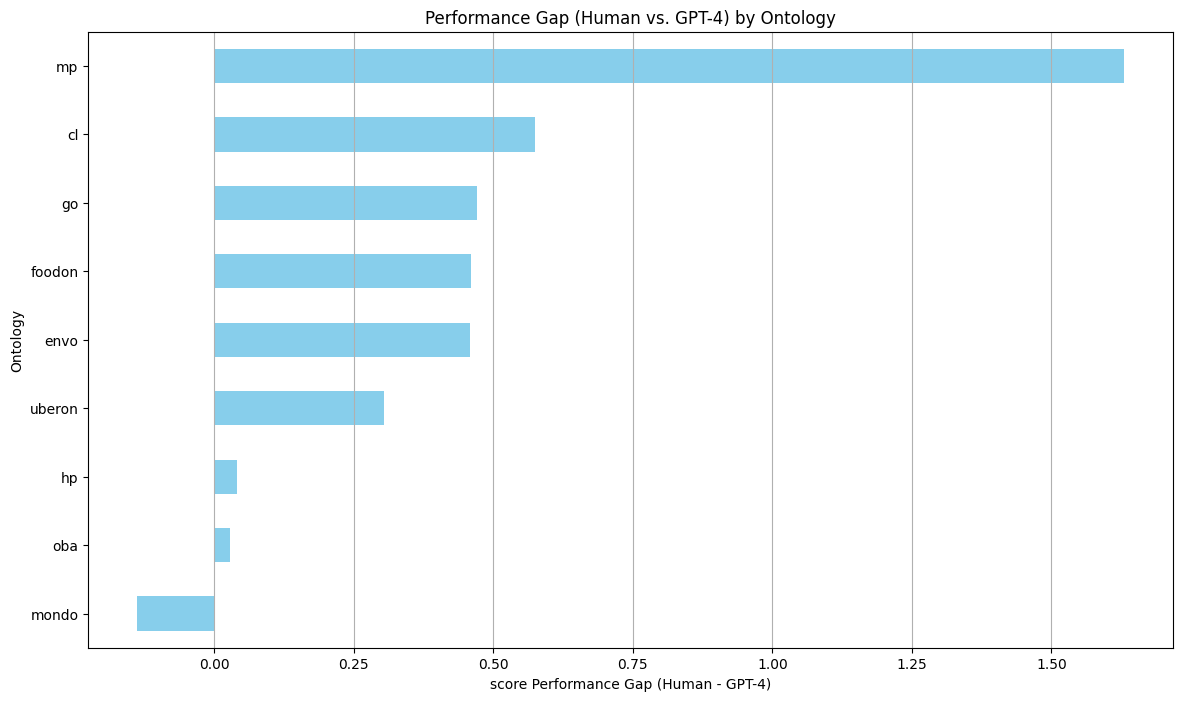

In [33]:
import matplotlib.pyplot as plt

# 1. Filter the data for the two models of interest ("human" and "gpt-4").
human_data = eval_data_base[eval_data_base['model_name'] == 'human']
gpt4_data = eval_data_base[eval_data_base['model_name'] == 'gpt-4']

def gap_by_ontology(metric="score"):
    # 2. Group the data by ontology.
    # 3. For each ontology, compute the average score of each model.
    human_avg_scores_by_ontology = human_data.groupby('ontology')[metric].mean()
    gpt4_avg_scores_by_ontology = gpt4_data.groupby('ontology')[metric].mean()
    
    # 4. Calculate the performance gap for each ontology.
    performance_gap_by_ontology = human_avg_scores_by_ontology - gpt4_avg_scores_by_ontology
    
    # 5. Plot the performance gap for each ontology.
    plt.figure(figsize=(14, 8))
    performance_gap_by_ontology.sort_values().plot(kind='barh', color='skyblue')
    plt.title('Performance Gap (Human vs. GPT-4) by Ontology')
    plt.xlabel(f'{metric} Performance Gap (Human - GPT-4)')
    plt.ylabel('Ontology')
    plt.grid(axis='x')
    plt.show()
gap_by_ontology()

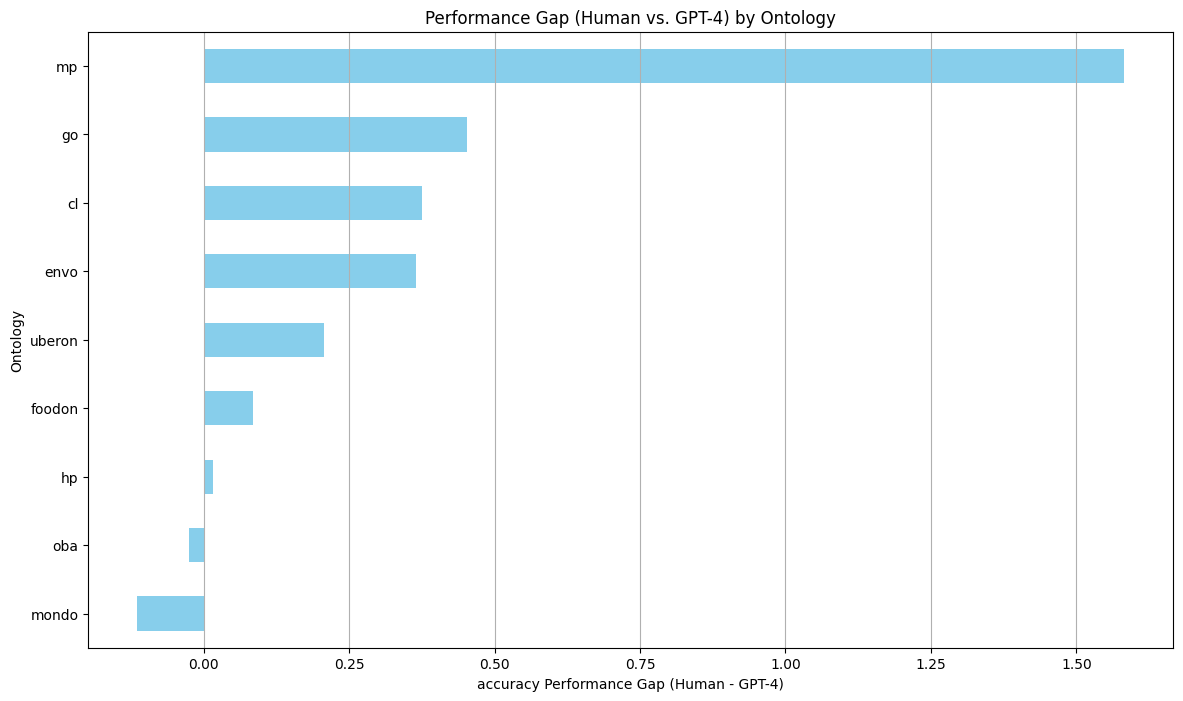

In [34]:
gap_by_ontology("accuracy")

In [35]:
pairwise_t_tests(eval_data_base.query("ontology == 'hp'"), 'accuracy')

,0,1,2,3
0,gpt-4,gpt-3.5-turbo,0.340146,False
1,gpt-4,human,0.892802,False
2,gpt-4,nous-hermes-13b,0.035248,False
3,gpt-3.5-turbo,human,0.294679,False
4,gpt-3.5-turbo,nous-hermes-13b,0.256236,False
5,human,nous-hermes-13b,0.030477,False


In [36]:
pairwise_t_tests(eval_data_base.query("ontology == 'mondo'"), 'accuracy')

,0,1,2,3
0,human,gpt-3.5-turbo,0.612126,False
1,human,nous-hermes-13b,0.387231,False
2,human,gpt-4,0.633296,False
3,gpt-3.5-turbo,nous-hermes-13b,0.019290,False
4,gpt-3.5-turbo,gpt-4,1.000000,False
5,nous-hermes-13b,gpt-4,0.022890,False


In [37]:
pairwise_t_tests(eval_data_base.query("ontology == 'hp'"), 'score')

,0,1,2,3
0,gpt-4,gpt-3.5-turbo,0.600253,False
1,gpt-4,human,0.784358,False
2,gpt-4,nous-hermes-13b,0.446961,False
3,gpt-3.5-turbo,human,0.432527,False
4,gpt-3.5-turbo,nous-hermes-13b,0.804574,False
5,human,nous-hermes-13b,0.312274,False


In [38]:
pairwise_t_tests(eval_data_base.query("ontology == 'mondo'"), 'score')

,0,1,2,3
0,human,gpt-3.5-turbo,0.631108,False
1,human,nous-hermes-13b,0.975530,False
2,human,gpt-4,0.657301,False
3,gpt-3.5-turbo,nous-hermes-13b,0.453456,False
4,gpt-3.5-turbo,gpt-4,0.953717,False
5,nous-hermes-13b,gpt-4,0.490047,False


## Differences increase as confidence decreases

In [39]:
scores_tbl(eval_data_base.query('method in ["RAG", "curator"] and confidence>4'))

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,4.158,3.714,3.869
RAG,gpt-4,4.079,3.653,3.842
RAG,nous-hermes-13b,3.728,3.321,3.601
curator,human,4.545,4.289,4.348


In [40]:
human_vs_gpt4 = eval_data_base.query("model_name == 'human' or model_name == 'gpt-4'")
human_vs_gpt4.to_csv("results/human_vs_gpt4.csv", index=False)


CONFIDENCE pearson: 0.997399511283657
CONFIDENCE spearman: 0.9999999999999999
CONFIDENCE kendall: 0.9999999999999999


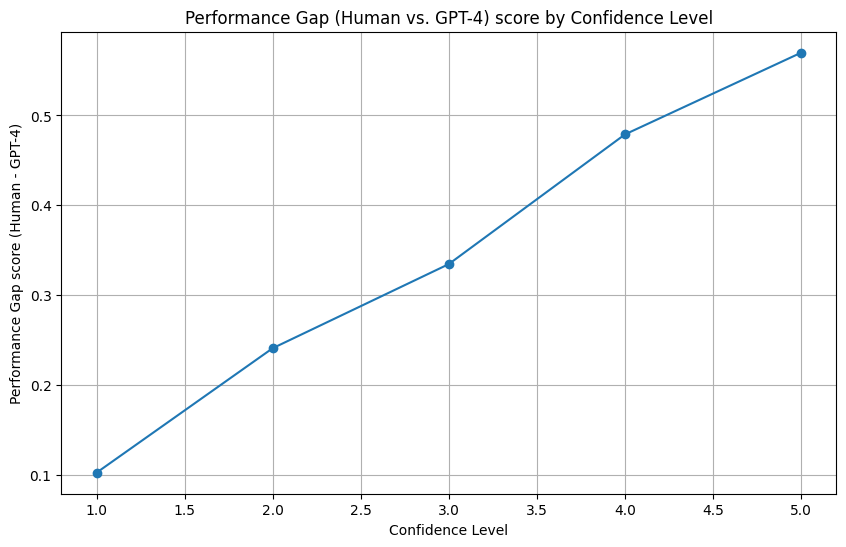

In [41]:
import matplotlib.pyplot as plt

def plot_gap(metric="score"):
    # Filter the data for the two models of interest
    human_data = eval_data_base[eval_data_base['model_name'] == 'human']
    gpt4_data = eval_data_base[eval_data_base['model_name'] == 'gpt-4']
    
    # Group by confidence level and compute the average score for each model
    human_avg_scores = human_data.groupby('confidence')[metric].mean()
    gpt4_avg_scores = gpt4_data.groupby('confidence')[metric].mean()
    
    # Calculate the performance gap for each confidence level
    performance_gap = human_avg_scores - gpt4_avg_scores
    
    # Assuming 'performance_gap' is a Series with numeric indices representing confidence levels
    # Convert the index to a numeric Series
    for m in ["pearson", "spearman", "kendall"]:

        confidence_numeric = pd.Series(range(len(performance_gap)), index=performance_gap.index)
        correlation_gap_confidence = performance_gap.corr(confidence_numeric, method=m)  
        print(f"CONFIDENCE {m}: {correlation_gap_confidence}")
    
    # Plot the performance gap against confidence levels
    plt.figure(figsize=(10, 6))
    performance_gap.plot(marker='o', linestyle='-')
    plt.title(f'Performance Gap (Human vs. GPT-4) {metric} by Confidence Level')
    plt.xlabel('Confidence Level')
    plt.ylabel(f'Performance Gap {metric} (Human - GPT-4)')
    plt.grid(True)
    plt.savefig(f"results/performance-gap-vs-confidence-{metric}.png")
    plt.show()
    
plot_gap("score")


CONFIDENCE pearson: 0.6977485369238388
CONFIDENCE spearman: 0.7
CONFIDENCE kendall: 0.6


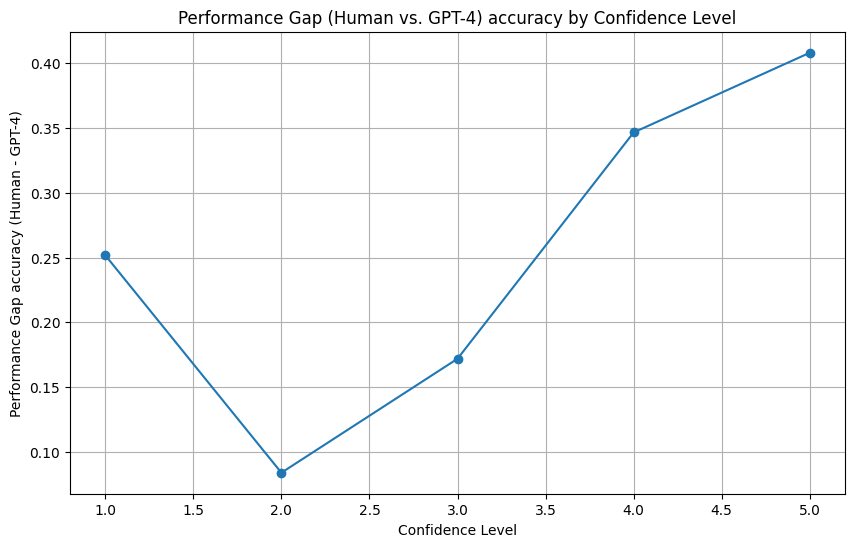

In [42]:
plot_gap("accuracy")

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/3056585534.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(performance_gap.index, performance_gap, yerr=performance_gap_std, fmt='o-', linestyle='-', capsize=5)


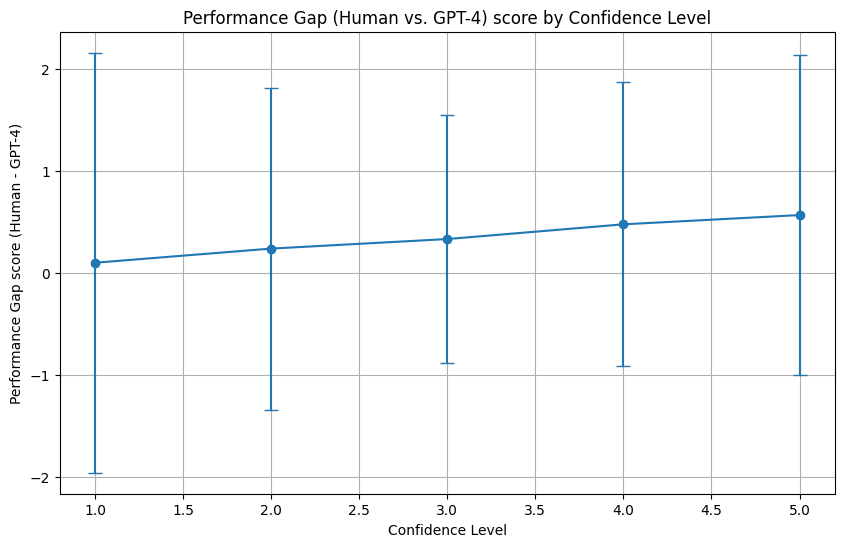

In [43]:
def plot_gap_with_stdev(metric="score"):
    # Filter the data for the two models of interest
    human_data = eval_data_base[eval_data_base['model_name'] == 'human']
    gpt4_data = eval_data_base[eval_data_base['model_name'] == 'gpt-4']
    
    human_stats = human_data.groupby('confidence')[metric].agg(['mean', 'std'])
    gpt4_stats = gpt4_data.groupby('confidence')[metric].agg(['mean', 'std'])
    performance_gap = human_stats['mean'] - gpt4_stats['mean']
    performance_gap_std = np.sqrt(human_stats['std']**2 + gpt4_stats['std']**2)
    
    # Plot the performance gap against confidence levels
    plt.figure(figsize=(10, 6))
    plt.errorbar(performance_gap.index, performance_gap, yerr=performance_gap_std, fmt='o-', linestyle='-', capsize=5)
    #performance_gap.plot(marker='o', linestyle='-')
    plt.title(f'Performance Gap (Human vs. GPT-4) {metric} by Confidence Level')
    plt.xlabel('Confidence Level')
    plt.ylabel(f'Performance Gap {metric} (Human - GPT-4)')
    plt.grid(True)
    plt.savefig(f"results/performance-gap-vs-confidence-{metric}-woth-stddev.png")
    plt.show()
    
plot_gap_with_stdev("score")

In [44]:
#sns.boxplot(data=performance_gap.reset_index(), x='index', y=0)
#type(performance_gap)
#performance_gap
#performance_gap.reset_index()
#sns.boxplot(data=performance_gap.reset_index(), x='confidence', y='score')
#human_data - gpt4_data

In [45]:
# Convert the index (confidence levels) to a series and calculate the correlation with the performance gap
#correlation_gap_confidence = performance_gap.corr(pd.Series(performance_gap.index, index=performance_gap.index))

#correlation_gap_confidence


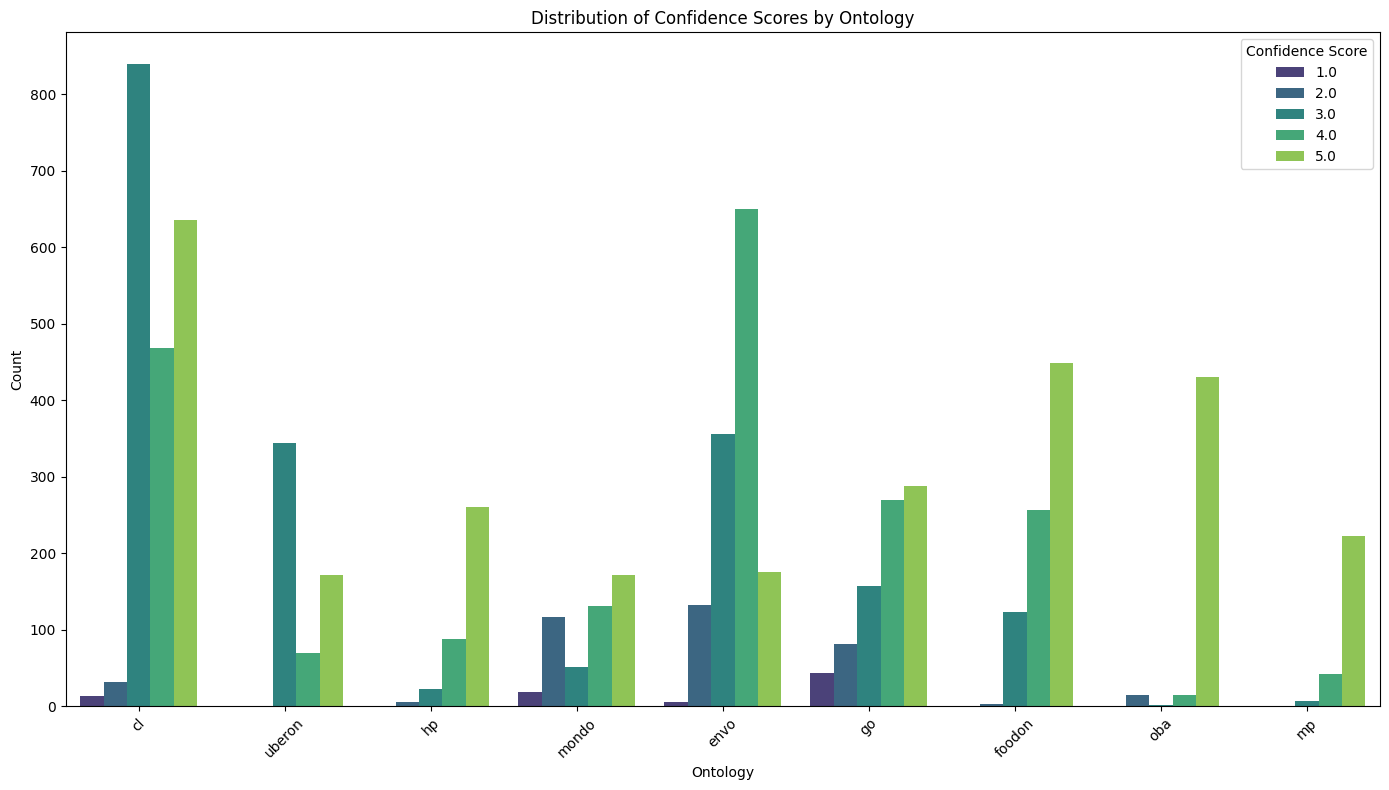

In [46]:
import seaborn as sns

# Create a bar chart to display the frequency of each confidence score for every ontology
plt.figure(figsize=(14, 8))
sns.countplot(data=eval_data, x='ontology', hue='confidence', palette="viridis")
plt.title('Distribution of Confidence Scores by Ontology')
plt.xlabel('Ontology')
plt.ylabel('Count')
plt.legend(title='Confidence Score', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Adding GitHub as background increases performance across all scores

Note that the addition of GitHub was only performed for 3 ontologies

In [47]:
eval_data_gh = eval_data.query('method in ["RAG", "RAG+github", "curator"] and ontology in ["cl", "envo", "uberon"]')
#eval_data_gh["model_method"] = eval_data_gh["method"] + "_" + eval_data_gh["model_name"]

In [48]:
scores_tbl(eval_data_gh)

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,4.067,3.626,3.709
RAG,gpt-4,4.041,3.608,3.754
RAG,nous-hermes-13b,4.063,3.678,3.710
RAG+github,gpt-3.5-turbo,4.182,3.717,3.733
RAG+github,gpt-4,4.241,3.805,3.893
RAG+github,nous-hermes-13b,4.000,4.000,4.500
curator,human,4.439,4.158,4.182


In [49]:
pairwise_t_tests(eval_data_gh, "score", "method")

,0,1,2,3
0,RAG,curator,3.087468e-15,True
1,RAG,RAG+github,7.098049e-03,True
2,curator,RAG+github,7.678650e-08,True


In [50]:
pairwise_t_tests(eval_data_gh, "accuracy", "method")

,0,1,2,3
0,RAG,curator,1.124921e-07,True
1,RAG,RAG+github,3.697619e-03,True
2,curator,RAG+github,4.594322e-03,True


In [51]:
pairwise_t_tests(eval_data_gh, "consistency", "method")

,0,1,2,3
0,RAG,curator,6.682596e-10,True
1,RAG,RAG+github,1.553118e-01,False
2,curator,RAG+github,3.026333e-06,True


### All Methods

In [52]:
eval_data.dropna(subset=["consistency", "score", "accuracy"]).\
groupby(['method', 'model_name'])[["accuracy", "score", "consistency"]].mean().\
reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

,method,model_name,accuracy,score,consistency
0,RAG,gpt-3.5-turbo,4.058,3.632,3.735
1,RAG,gpt-4,3.970,3.567,3.689
2,RAG,nous-hermes-13b,3.776,3.389,3.566
3,RAG+background,gpt-3.5-turbo,4.122,3.518,3.418
4,RAG+background,gpt-4,4.134,3.317,3.113
5,RAG+background,nous-hermes-13b,3.933,3.800,3.867
6,RAG+background+github,gpt-3.5-turbo,4.043,3.086,3.071
7,RAG+background+github,gpt-4,3.956,2.897,2.897
8,RAG+devdocs,gpt-3.5-turbo,4.447,3.933,4.007
9,RAG+github,gpt-3.5-turbo,4.182,3.717,3.733


In [53]:
# all methods, CL only

eval_data.query("ontology=='cl'").\
dropna(subset=["consistency", "score", "accuracy"]).\
groupby(['method', 'model_name'])[["accuracy", "score", "consistency"]].mean().\
reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

,method,model_name,accuracy,score,consistency
0,RAG,gpt-3.5-turbo,4.366,3.924,4.014
1,RAG,gpt-4,4.309,3.822,3.980
2,RAG,nous-hermes-13b,4.250,3.868,3.875
3,RAG+background,gpt-3.5-turbo,4.390,3.604,3.442
4,RAG+background,gpt-4,4.413,3.713,3.607
5,RAG+devdocs,gpt-3.5-turbo,4.447,3.933,4.007
6,RAG+github,gpt-3.5-turbo,4.459,3.993,4.000
7,RAG+github,gpt-4,4.461,4.079,4.171
8,curator,human,4.760,4.435,4.422


In [54]:
eval_data.groupby(['method', 'model_name'])[["accuracy", "score", "consistency"]].mean().reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

,method,model_name,accuracy,score,consistency
0,RAG,gpt-3.5-turbo,4.065,3.627,3.736
1,RAG,gpt-4,4.012,3.581,3.689
2,RAG,nous-hermes-13b,3.841,3.448,3.568
3,RAG+background,gpt-3.5-turbo,4.155,3.601,3.419
4,RAG+background,gpt-4,4.144,3.449,3.118
5,RAG+background,nous-hermes-13b,4.500,4.281,3.867
6,RAG+background+github,gpt-3.5-turbo,4.043,3.223,3.071
7,RAG+background+github,gpt-4,3.956,3.029,2.897
8,RAG+devdocs,gpt-3.5-turbo,4.440,3.800,4.007
9,RAG+github,gpt-3.5-turbo,4.205,3.744,3.733


Because some values are null it's better to split this into 3 tables

In [55]:

def smry(k, this_df=eval_data):
    return this_df.dropna(subset=[k]).groupby(['method', 'model_name'])[[k]].mean().reset_index()

In [56]:
smry("score")

,method,model_name,score
0,RAG,gpt-3.5-turbo,3.627313
1,RAG,gpt-4,3.581116
2,RAG,nous-hermes-13b,3.447632
3,RAG+background,gpt-3.5-turbo,3.601215
4,RAG+background,gpt-4,3.449388
5,RAG+background,nous-hermes-13b,4.281250
6,RAG+background+github,gpt-3.5-turbo,3.222857
7,RAG+background+github,gpt-4,3.029412
8,RAG+devdocs,gpt-3.5-turbo,3.800000
9,RAG+github,gpt-3.5-turbo,3.743820


In [57]:
smry("accuracy")

,method,model_name,accuracy
0,RAG,gpt-3.5-turbo,4.064663
1,RAG,gpt-4,4.012433
2,RAG,nous-hermes-13b,3.841016
3,RAG+background,gpt-3.5-turbo,4.155462
4,RAG+background,gpt-4,4.144186
5,RAG+background,nous-hermes-13b,4.500000
6,RAG+background+github,gpt-3.5-turbo,4.042857
7,RAG+background+github,gpt-4,3.955882
8,RAG+devdocs,gpt-3.5-turbo,4.440367
9,RAG+github,gpt-3.5-turbo,4.205418


In [58]:
smry("consistency")

,method,model_name,consistency
0,RAG,gpt-3.5-turbo,3.735799
1,RAG,gpt-4,3.689032
2,RAG,nous-hermes-13b,3.567531
3,RAG+background,gpt-3.5-turbo,3.419306
4,RAG+background,gpt-4,3.118056
5,RAG+background,nous-hermes-13b,3.866667
6,RAG+background+github,gpt-3.5-turbo,3.071429
7,RAG+background+github,gpt-4,2.897059
8,RAG+devdocs,gpt-3.5-turbo,4.006667
9,RAG+github,gpt-3.5-turbo,3.732558


In [59]:
# 1. Load the data
eval_df_direct = eval_data

# 2. Group by ontology, method, and model_name and compute the average scores
grouped_df_direct = eval_df_direct.groupby(['ontology', 'method', 'model_name']).agg({
    'accuracy': 'mean',
    'consistency': 'mean',
    'score': 'mean'
}).reset_index()

# 3. Pivot the table to create a multi-level column header
pivoted_multiindex_direct = grouped_df_direct.set_index(['method', 'model_name', 'ontology']).unstack('ontology')

# 4. Display the MultiIndex table with average scores
pivoted_multiindex_direct.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)


In [60]:
pivoted_multiindex_direct.dropna().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [61]:
eval_data=subset
summary_data = eval_data.groupby(['method', 'model_name']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_consistency=('consistency', 'mean'),
    mean_score=('score', 'mean')
).reset_index()

# Step 3: Find the top-performing method for each criterion
top_accuracy_method = summary_data.loc[summary_data['mean_accuracy'].idxmax(), ['method', 'model_name', 'mean_accuracy']]
top_consistency_method = summary_data.loc[summary_data['mean_consistency'].idxmax(), ['method', 'model_name', 'mean_consistency']]
top_score_method = summary_data.loc[summary_data['mean_score'].idxmax(), ['method', 'model_name', 'mean_score']]

# Step 4: Create a table with the top-performing methods
top_methods_table = pd.DataFrame([top_accuracy_method, top_consistency_method, top_score_method], index=['Top Accuracy', 'Top Internal Consistency', 'Top Score'])

# Step 5: Display the table
print(top_methods_table)



                                  method       model_name  mean_accuracy  \
Top Accuracy              RAG+background  nous-hermes-13b            4.5   
Top Internal Consistency      RAG+github  nous-hermes-13b            NaN   
Top Score                 RAG+background  nous-hermes-13b            NaN   

                          mean_consistency  mean_score  
Top Accuracy                           NaN         NaN  
Top Internal Consistency               4.5         NaN  
Top Score                              NaN     4.28125  


In [62]:
eval_data.groupby(['method', 'model_name', 'ontology']).size()

method                 model_name       ontology
RAG                    gpt-3.5-turbo    cl          212
                                        envo        160
                                        foodon      175
                                        go          173
                                        hp           96
                                        mondo        94
                                        mp           67
                                        oba          92
                                        uberon       66
                       gpt-4            cl          223
                                        envo        164
                                        foodon      174
                                        go          178
                                        hp           95
                                        mondo        94
                                        mp           68
                                        oba          92

## Effects of including GitHub as a background source

We only used github as an additional background for cl and envo (and uberon, but insufficient evaluations here)

In [63]:
cl_envo = eval_data.query("ontology == 'cl' or ontology == 'envo'")
smry("consistency", cl_envo)

,method,model_name,consistency
0,RAG,gpt-3.5-turbo,3.635556
1,RAG,gpt-4,3.670940
2,RAG,nous-hermes-13b,3.697368
3,RAG+background,gpt-3.5-turbo,3.288136
4,RAG+background,gpt-4,3.402597
5,RAG+devdocs,gpt-3.5-turbo,4.006667
6,RAG+github,gpt-3.5-turbo,3.666667
7,RAG+github,gpt-4,3.844828
8,curator,human,4.145669


In [64]:
smry("score", cl_envo)

,method,model_name,score
0,RAG,gpt-3.5-turbo,3.543011
1,RAG,gpt-4,3.537468
2,RAG,nous-hermes-13b,3.668000
3,RAG+background,gpt-3.5-turbo,3.605670
4,RAG+background,gpt-4,3.653543
5,RAG+devdocs,gpt-3.5-turbo,3.800000
6,RAG+github,gpt-3.5-turbo,3.655172
7,RAG+github,gpt-4,3.733681
8,curator,human,4.030588


In [65]:
smry("accuracy", cl_envo)

,method,model_name,accuracy
0,RAG,gpt-3.5-turbo,3.983827
1,RAG,gpt-4,3.989583
2,RAG,nous-hermes-13b,4.075067
3,RAG+background,gpt-3.5-turbo,4.194301
4,RAG+background,gpt-4,4.261905
5,RAG+devdocs,gpt-3.5-turbo,4.440367
6,RAG+github,gpt-3.5-turbo,4.117333
7,RAG+github,gpt-4,4.186352
8,curator,human,4.319149


In [66]:
# Combine 'method' and 'model_name' to create a new column for the x-axis
eval_data['method_model'] = eval_data['method'] + ' + ' + eval_data['model_name']

In [67]:
grouped_data_stats = eval_data.groupby(['method', 'model_name'], as_index=False).agg({
    'accuracy': ['mean', 'std', 'count'],
    'consistency': ['mean', 'std', 'count'],
    'score': ['mean', 'std', 'count']
})
grouped_data_stats

method       model_name  accuracy                  \
                                                mean       std count   
0                     RAG    gpt-3.5-turbo  4.064663  1.082053  1098   
1                     RAG            gpt-4  4.012433  1.110686  1126   
2                     RAG  nous-hermes-13b  3.841016  1.223642  1063   
3          RAG+background    gpt-3.5-turbo  4.155462  0.979813   952   
4          RAG+background            gpt-4  4.144186  1.002976   860   
5          RAG+background  nous-hermes-13b  4.500000  1.107161    32   
6   RAG+background+github    gpt-3.5-turbo  4.042857  0.935867   140   
7   RAG+background+github            gpt-4  3.955882  0.987834   136   
8             RAG+devdocs    gpt-3.5-turbo  4.440367  0.968929   218   
9              RAG+github    gpt-3.5-turbo  4.205418  1.097413   443   
10             RAG+github            gpt-4  4.266219  0.987954   447   
11             RAG+github  nous-hermes-13b  4.500000  1.000000     4   
12                curator            human  4.326325  0.874829  1094   

   consistency                     score                  
          mean       std count      mean       std count  
0     3.735799  1.095421   757  3.627313  1.155217  1135  
1     3.689032  1.081950   775  3.581116  1.137303  1165  
2     3.567531  1.158190   733  3.447632  1.212679  1098  
3     3.419306  1.105761   663  3.601215  1.103957   988  
4     3.118056  1.137482   576  3.449388  1.155237   899  
5     3.866667  1.060099    15  4.281250  1.084625    32  
6     3.071429  1.122964   140  3.222857  1.078282   175  
7     2.897059  1.150069   136  3.029412  1.062689   170  
8     4.006667  1.114256   150  3.800000  1.108704   220  
9     3.732558  1.174546   258  3.743820  1.139776   445  
10    3.892720  1.118027   261  3.819599  1.037669   449  
11    4.500000  0.707107     2  4.000000  0.816497     4  
12    4.129074  0.877795   767  4.049426  0.959991  1133

In [68]:
# filter eval_data so that only (method, model_name) pairs with at least 1000 evaluations are included
eval_data_filtered = eval_data[eval_data.groupby(['method', 'model_name'])['score'].transform('count') >= 400]
eval_data_filtered.groupby(['method', 'model_name'], as_index=False).agg({
    'accuracy': ['mean', 'std', 'count'],
    'consistency': ['mean', 'std', 'count'],
    'score': ['mean', 'std', 'count']
})

method       model_name  accuracy                 consistency  \
                                        mean       std count        mean   
0             RAG    gpt-3.5-turbo  4.064663  1.082053  1098    3.735799   
1             RAG            gpt-4  4.012433  1.110686  1126    3.689032   
2             RAG  nous-hermes-13b  3.841016  1.223642  1063    3.567531   
3  RAG+background    gpt-3.5-turbo  4.155462  0.979813   952    3.419306   
4  RAG+background            gpt-4  4.144186  1.002976   860    3.118056   
5      RAG+github    gpt-3.5-turbo  4.205418  1.097413   443    3.732558   
6      RAG+github            gpt-4  4.266219  0.987954   447    3.892720   
7         curator            human  4.326325  0.874829  1094    4.129074   

                      score                  
        std count      mean       std count  
0  1.095421   757  3.627313  1.155217  1135  
1  1.081950   775  3.581116  1.137303  1165  
2  1.158190   733  3.447632  1.212679  1098  
3  1.105761   663  3.601215  1.103957   988  
4  1.137482   576  3.449388  1.155237   899  
5  1.174546   258  3.743820  1.139776   445  
6  1.118027   261  3.819599  1.037669   449  
7  0.877795   767  4.049426  0.959991  1133

## Summary Barcharts

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

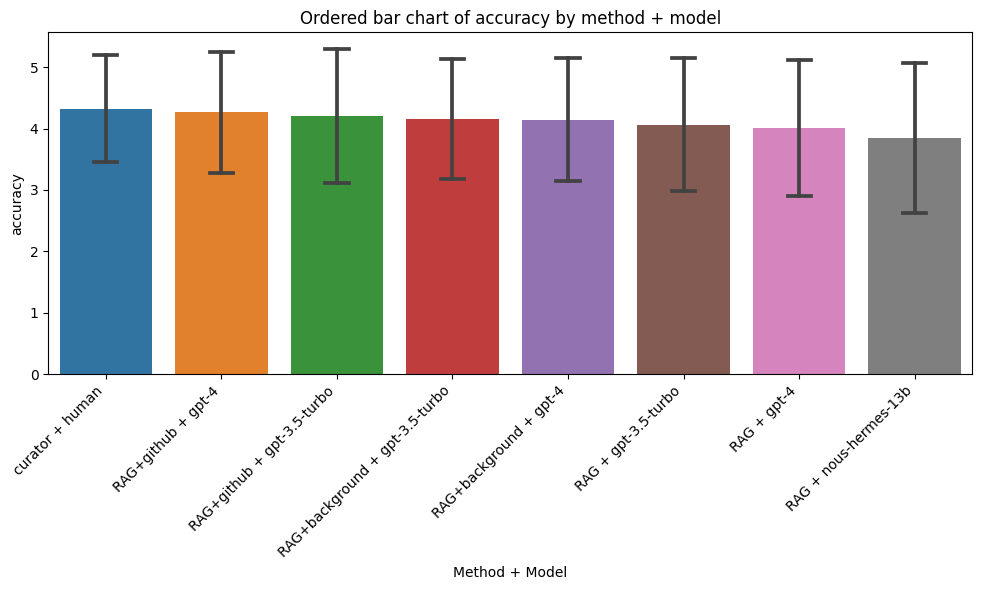

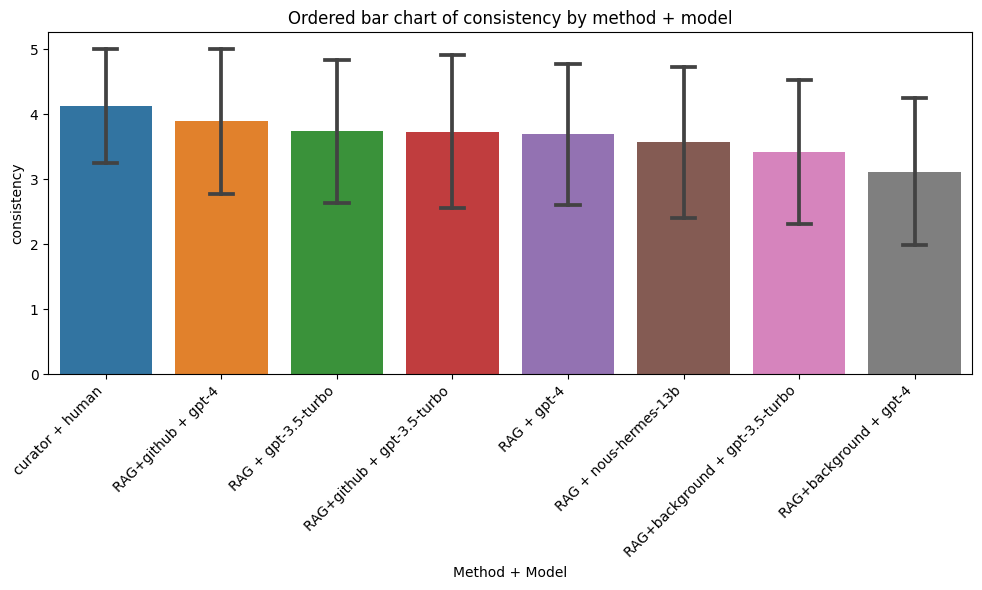

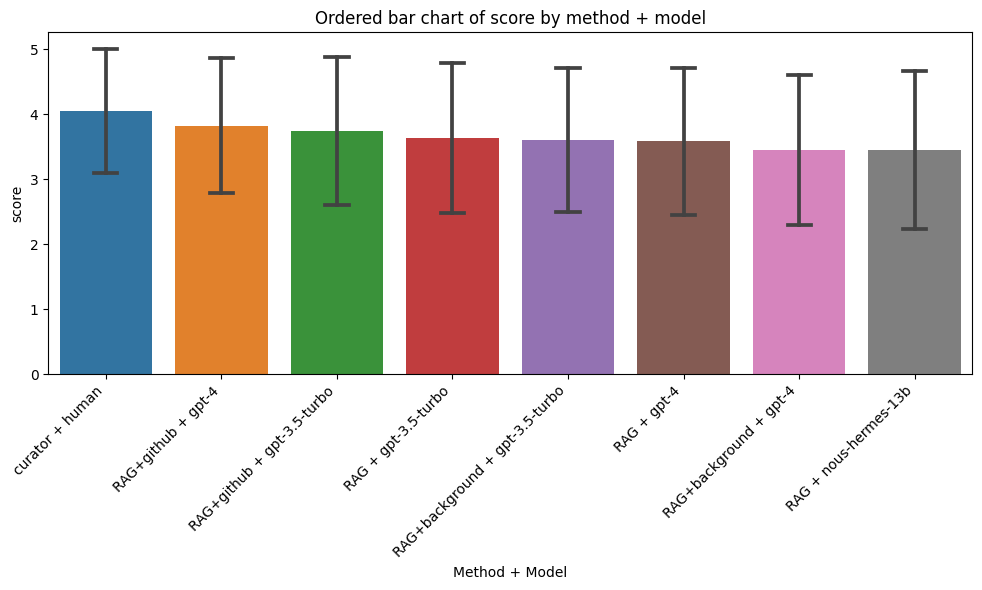

In [70]:
metrics = ['accuracy', 'consistency', 'score']



def plot_metric(metric, data, save=False):
    # Calculate the average for ordering
    order = data.groupby('method_model')[metric].mean().sort_values(ascending=False).index
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data,
        x='method_model',
        y=metric,
        order=order,  # Ordering the x-axis based on the average value of the metric
        capsize=.2,  # Adding error bars
        errorbar='sd'  # Using standard deviation for error bars
    )
    plt.title(f'Ordered bar chart of {metric} by method + model')
    plt.ylabel(f'{metric}')
    plt.xlabel('Method + Model')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"results/definition-eval-figure-{metric}.png")
    plt.show()

for metric in metrics:
    plot_metric(metric, eval_data_filtered, True)


/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')


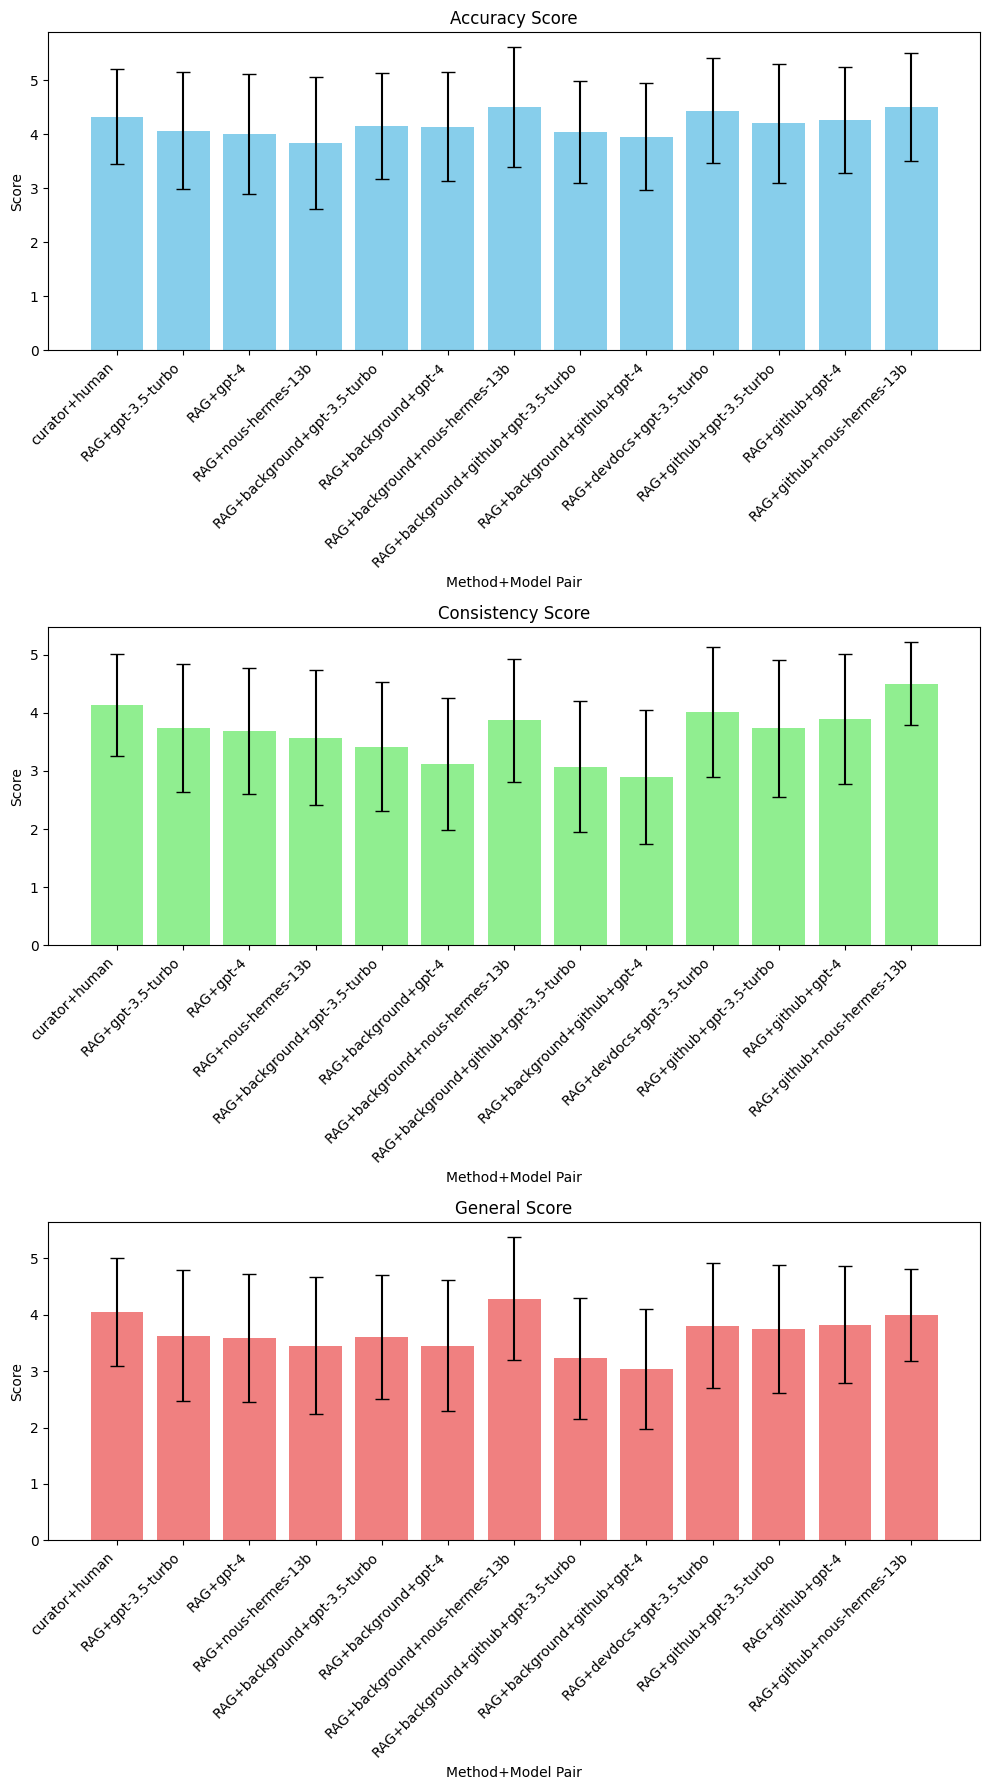

In [71]:
def scorecharts(eval_data):
    # Grouping the data by method and model_name and calculating the mean and standard deviation of the scores
    grouped_data_stats = eval_data.groupby(['method', 'model_name'], as_index=False).agg({
        'accuracy': ['mean', 'std'],
        'consistency': ['mean', 'std'],
        'score': ['mean', 'std']
    })
    
    # Creating a new column to represent method+model pair
    grouped_data_stats['method_model'] = grouped_data_stats['method'] + '+' + grouped_data_stats['model_name']
    
    # Separating the 'curator' rows from the data
    curator_rows = grouped_data_stats[grouped_data_stats['method'] == 'curator']
    
    # Separating the non-'curator' rows from the data
    non_curator_rows = grouped_data_stats[grouped_data_stats['method'] != 'curator']
    
    # Concatenating the 'curator' rows at the beginning
    ordered_data_stats = pd.concat([curator_rows, non_curator_rows], ignore_index=True)
    
    # Plotting bar charts for each score type with error bars
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))
    
    # Plotting bar chart for accuracy score with error bars
    ax[0].bar(ordered_data_stats['method_model'], ordered_data_stats['accuracy']['mean'], 
              yerr=ordered_data_stats['accuracy']['std'], color='skyblue', capsize=5)
    ax[0].set_title('Accuracy Score')
    ax[0].set_ylabel('Score')
    ax[0].set_xlabel('Method+Model Pair')
    ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Plotting bar chart for consistency score with error bars
    ax[1].bar(ordered_data_stats['method_model'], ordered_data_stats['consistency']['mean'], 
              yerr=ordered_data_stats['consistency']['std'], color='lightgreen', capsize=5)
    ax[1].set_title('Consistency Score')
    ax[1].set_ylabel('Score')
    ax[1].set_xlabel('Method+Model Pair')
    ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Plotting bar chart for general score with error bars
    ax[2].bar(ordered_data_stats['method_model'], ordered_data_stats['score']['mean'], 
              yerr=ordered_data_stats['score']['std'], color='lightcoral', capsize=5)
    ax[2].set_title('General Score')
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel('Method+Model Pair')
    ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Adjusting the layout to prevent overlap
    plt.tight_layout()

# Display the plots

scorecharts(eval_data)
plt.savefig("results/definition-eval-figure.png")
plt.show()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/58816721.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')


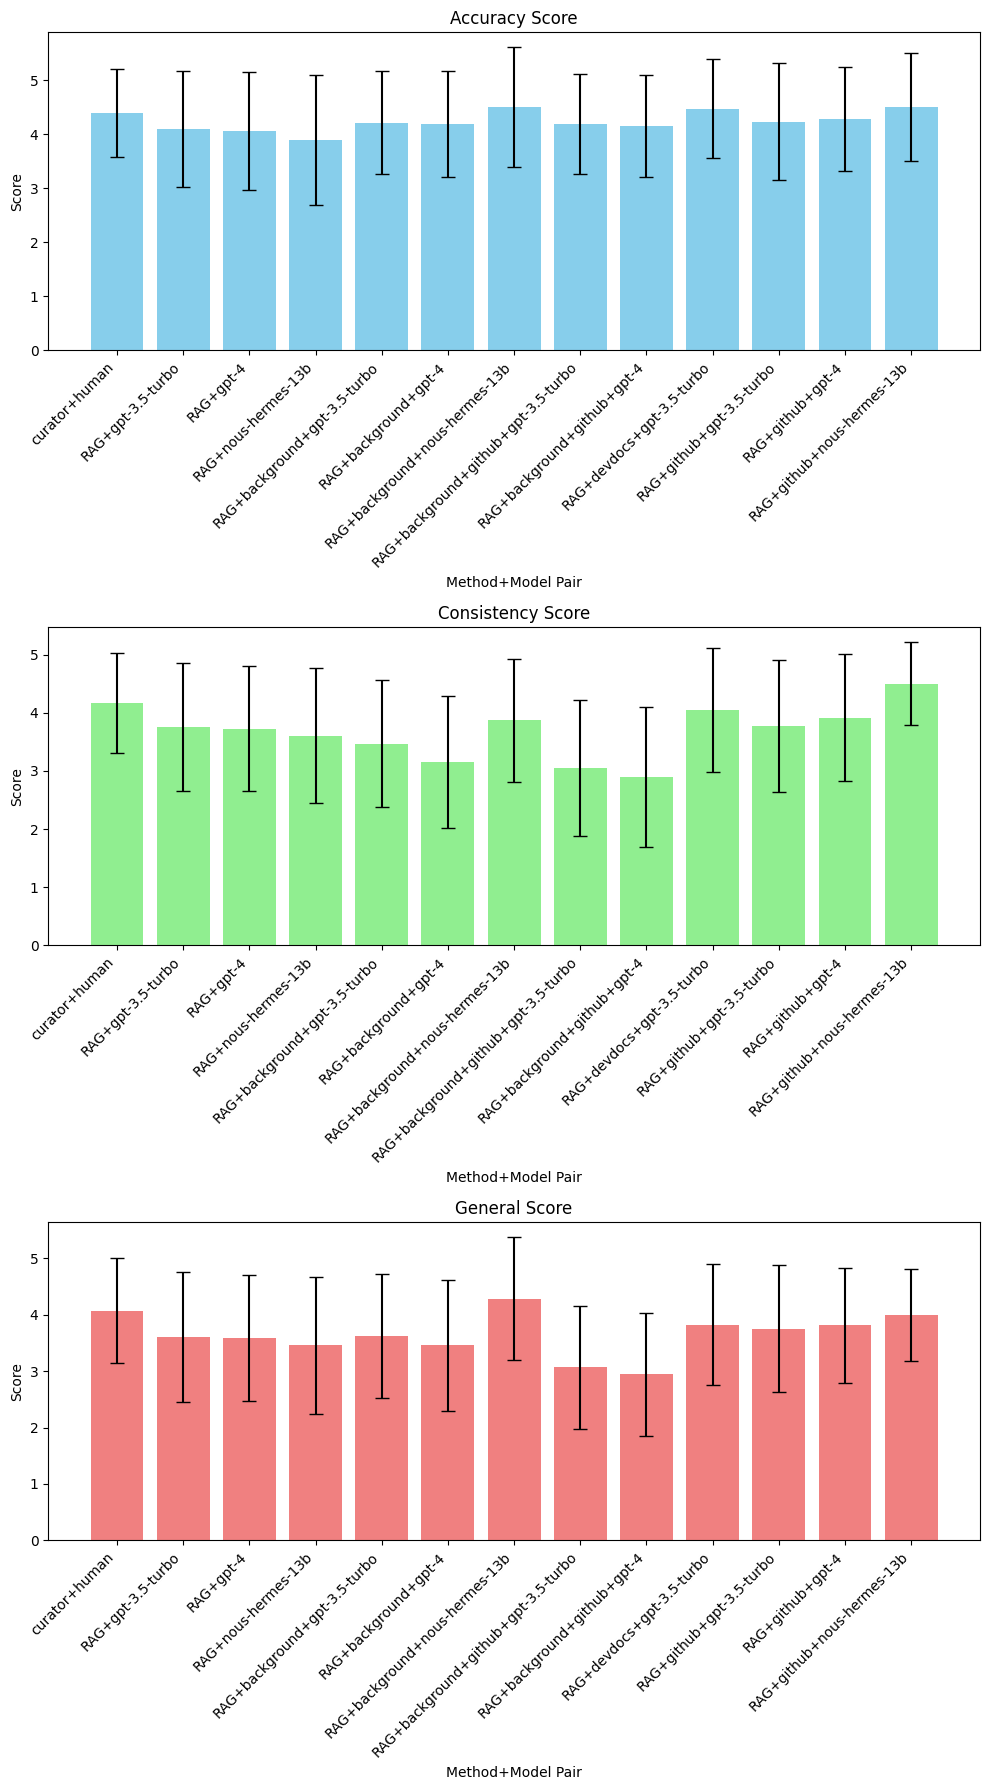

In [72]:
scorecharts(eval_data.query("confidence > 2.0"))

## Effect of github

In [73]:
from scipy.stats import ttest_ind


In [74]:
def compare_methods(method1, method2, model="gpt-4", metric="consistency"):

    scores1 = eval_data[(eval_data['method'] == method1)]
    if model and method1 != "curator":
        scores1 = scores1[scores1['model_name'] == model]
    scores1 = scores1[metric]
    scores2 = eval_data[(eval_data['method'] == method2)]
    if model:
        scores2 = scores2[scores2['model_name'] == model]
    scores2 = scores2[metric]

    # Conducting the t-test
    t_stat_bg, p_value_bg = ttest_ind(scores1.dropna(), scores2.dropna())

    return t_stat_bg, p_value_bg


compare_methods("RAG", "RAG+github")

(-2.6084269489195937, 0.009227134671310252)

In [75]:
compare_methods("RAG", "RAG+github", None)

(-2.7642866184858534, 0.005742303198348302)

In [76]:
compare_methods("RAG", "RAG+github", "gpt-3.5-turbo")

(0.040284546029524616, 0.9678742121888037)

In [77]:
compare_methods("RAG", "RAG+github", metric="score")

(-3.866068908077133, 0.00011499652094335828)

In [78]:
compare_methods("RAG", "RAG+github", metric="accuracy")

(-4.21408586960442, 2.650571039521872e-05)

In [79]:
compare_methods("curator", "no_RAG", metric="score")

(nan, nan)

In [80]:
compare_methods("curator", "no_RAG", metric="accuracy")

(nan, nan)

In [81]:
compare_methods("curator", "RAG", metric="score")

(10.65254482172634, 6.754554266621985e-26)

In [82]:
compare_methods("curator", "RAG+github", metric="score")

(4.194128227216874, 2.8912981292716847e-05)

In [83]:
compare_methods("curator", "RAG+github", metric="consistency")

(3.492173400998647, 0.000499517481223898)

## Inter-evaluation consistency

The data contains various columns, including accuracy, consistency, and score, which are the scoring metrics for which we need to calculate inter-evaluator consistency. The scores are continuous, and there are multiple evaluators, which makes the Intraclass Correlation Coefficient (ICC) a suitable measure for assessing inter-evaluator consistency.

Let's proceed to calculate the ICC for each of the three metrics (accuracy, consistency, score). ICC values typically range from 0 to 1, where 0.75≤ICC<0.9 indicates good reliability.

In [84]:
eval_data["confidence"].unique()

array([3.0, 4.0, 5.0, 2.0, 1.0, nan], dtype=object)

In [85]:
pd.options.mode.chained_assignment = None  # default='warn'

import statsmodels.api as sm
from statsmodels.formula.api import ols

def calculate_icc_oneway(data, metric):
    # Removing rows with missing values in the specified metric
    data = data[['evaluator', 'label', metric]].dropna()
    # Fitting the one-way ANOVA model
    model = ols(f'{metric} ~ C(evaluator)', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=1)
    
    # Getting the mean squares
    msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
    mse = anova_table['sum_sq'].iloc[1] / anova_table['df'].iloc[1]
    
    # Number of ratings per target
    k = len(data['evaluator'].unique())
    
    # Calculating ICC(1,1)
    icc = (msb - mse) / (msb + (k - 1) * mse)
    
    return icc

def calculate_all_icc(data, min_confidence=0):
    data = data[data['confidence'] > min_confidence]
    # Calculating ICC for 'accuracy', 'consistency', and 'score'
    icc_accuracy = calculate_icc_oneway(data, 'accuracy')
    icc_consistency = calculate_icc_oneway(data, 'consistency')
    icc_score = calculate_icc_oneway(data, 'score')

    return icc_accuracy, icc_consistency, icc_score

calculate_all_icc(eval_data)


(0.8221781066562716, 0.7688058052500838, 0.7810302204354226)

In [86]:

calculate_all_icc(eval_data, 3.0)

(0.7020227473903702, 0.7043473901839006, 0.6728626043850497)

In [87]:
rows = []
for ontology in eval_data["ontology"].unique():
    data = eval_data[eval_data["ontology"] == ontology]
    icc = calculate_all_icc(data)
    print(ontology, len(data["evaluator"].unique()), icc)
    rows.append({"ontology":ontology, "num_evaluators": len(data["evaluator"].unique()),
                 "accuracy":icc[0], "consistency":icc[1], "score":icc[2]})
icc_by_ont = pd.DataFrame(rows)
icc_by_ont

cl 10 (0.9052631409724602, 0.750230345922195, 0.8516253374415731)
uberon 2 (0.9880047971358626, nan, 0.851070261478484)
hp 2 (0.6685345818979072, nan, 0.9596073966378771)
mondo 2 (0.9470594978352468, 0.9049474384512961, 0.9343497454888144)
envo 3 (0.9343860859273908, nan, 0.9718900474381321)
go 4 (0.2782199428459117, 0.8680498690244527, 0.23543387376731936)
foodon 5 (0.9583369451950258, 0.8596969301595625, 0.922445581934519)
oba 2 (0.9375659908306624, 0.9904447602003542, 0.9613789602272433)
mp 2 (0.3914999219835487, 0.9458446436766142, -0.4925469407653619)


/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_97908/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]


,ontology,num_evaluators,accuracy,consistency,score
0,cl,10,0.905263,0.750230,0.851625
1,uberon,2,0.988005,NaN,0.851070
2,hp,2,0.668535,NaN,0.959607
3,mondo,2,0.947059,0.904947,0.934350
4,envo,3,0.934386,NaN,0.971890
5,go,4,0.278220,0.868050,0.235434
6,foodon,5,0.958337,0.859697,0.922446
7,oba,2,0.937566,0.990445,0.961379
8,mp,2,0.391500,0.945845,-0.492547


In [88]:
go = eval_data[eval_data["ontology"] == "go"]

In [89]:
go

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
4751,bb1e6c76c178daba37fbc45d1bd4baff4d47be80c22ed2...,go,radial spoke 1,A component of the radial spoke complex that i...,4.0,NaN,4.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4752,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,radial spoke 1,A component of the radial spoke complex that i...,5.0,3.0,3.0,2.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4753,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,radial spoke 1,A component of the radial spoke complex that i...,3.0,3.0,3.0,NaN,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4754,d1525b556eb9ee23947be85c87445db74734dd3420272d...,go,radial spoke 1,A component of the radial spoke complex that i...,3.0,2.0,2.0,5.0,RAG+background,gpt-3.5-turbo,does not explain,RAG+background + gpt-3.5-turbo
4755,bb1e6c76c178daba37fbc45d1bd4baff4d47be80c22ed2...,go,radial spoke 1,The radial spoke of each group of radial spoke...,4.0,NaN,4.0,3.0,curator,human,"unclear what is the ""1"" versus ""2""",curator + human
...,...,...,...,...,...,...,...,...,...,...,...,...
7172,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,protein-glutathione oxidoreductase (glutathion...,The enzymatic process that involves the transf...,5.0,4.0,4.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
7173,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,protein-glutathione oxidoreductase (glutathion...,The enzymatic process that involves the transf...,4.0,2.0,4.0,2.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
7175,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,non-canonical inflammasome complex,"An inflammasome complex containing CASP4, know...",2.0,2.0,2.0,1.0,curator,human,NaN,curator + human
7176,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,non-canonical inflammasome complex,"An inflammasome complex containing CASP4, know...",5.0,NaN,5.0,1.0,curator,human,NaN,curator + human


## Inconsistent definition scoring

Here we hone in on specific examples of definitions that have been scored differently

In [90]:
def inconsistent_scores(data, metric="score", min_confidence=0, N=20):
    """
    Returns top N definitionswith the most inconsistent scores
    
    :param data: 
    :param metric: 
    :param min_confidence: 
    :param N: 
    :return: 
    """
    data = data[data["confidence"] > min_confidence]
    score_std = data.groupby(["definition"])[metric].std(numeric_only=True).reset_index().dropna()
    score_std = score_std.sort_values(by=metric, ascending=False)
    defns = score_std[0:N]['definition'].unique()
    return data[data["definition"].isin(defns)]
    
    

#score_std = eval_data.groupby(["definition"])["score"].std(numeric_only=True).reset_index().dropna()
#score_std = score_std.sort_values(by="score", ascending=False)
inconsistent_scores(eval_data)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
1227,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,NaN,5.0,3.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1228,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,1.0,3.0,1.0,5.0,RAG,nous-hermes-13b,"It is not defining basal cells, but the submuc...",RAG + nous-hermes-13b
1229,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,4.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
2074,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,calf,"A young bovine animal, specifically a young do...",5.0,NaN,5.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
2075,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,calf,"A young bovine animal, specifically a young do...",1.0,1.0,1.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
2078,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,front hindlimb zeugopod,The frontal aspect of the lower extremity that...,5.0,NaN,2.0,3.0,curator,human,NaN,curator + human
2079,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,front hindlimb zeugopod,The frontal aspect of the lower extremity that...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
2216,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,left supraclavicular lymph node,The left supraclavicular lymph node is a type ...,5.0,NaN,5.0,3.0,RAG+background,nous-hermes-13b,NaN,RAG+background + nous-hermes-13b
2217,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,left supraclavicular lymph node,The left supraclavicular lymph node is a type ...,2.0,3.0,2.0,4.0,RAG+background,nous-hermes-13b,NaN,RAG+background + nous-hermes-13b
2616,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,hp,Reduced epidermal plectin protein expression,Reduced expression of plectin protein in the e...,2.0,NaN,1.0,4.0,RAG,gpt-3.5-turbo,vague/incorrect,RAG + gpt-3.5-turbo


In [91]:
inconsistent_scores(eval_data, min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
339,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,late spermatid,A specialized cell that progresses from an ear...,3.0,NaN,2.0,5.0,RAG+background,gpt-3.5-turbo,too little detail,RAG+background + gpt-3.5-turbo
340,e66016570cfafca08140913fe701f02954a11fde7f8660...,cl,late spermatid,A specialized cell that progresses from an ear...,5.0,4.0,5.0,5.0,RAG+background,gpt-3.5-turbo,not g-d,RAG+background + gpt-3.5-turbo
515,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,2.0,NaN,2.0,5.0,RAG+background,gpt-3.5-turbo,This is vague,RAG+background + gpt-3.5-turbo
517,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,5.0,5.0,5.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
933,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,2.0,NaN,1.0,5.0,RAG+devdocs,gpt-3.5-turbo,Reiterates the label,RAG+devdocs + gpt-3.5-turbo
936,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,5.0,5.0,5.0,5.0,RAG+devdocs,gpt-3.5-turbo,NaN,RAG+devdocs + gpt-3.5-turbo
1228,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,1.0,3.0,1.0,5.0,RAG,nous-hermes-13b,"It is not defining basal cells, but the submuc...",RAG + nous-hermes-13b
1229,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,4.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1264,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,1.0,1.0,1.0,5.0,RAG,gpt-3.5-turbo,NaN,RAG + gpt-3.5-turbo
1265,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,5.0,4.0,5.0,5.0,RAG,gpt-3.5-turbo,The definition is the same as the label.,RAG + gpt-3.5-turbo


In [92]:
inconsistent_scores(eval_data, metric="accuracy", min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
320,e66016570cfafca08140913fe701f02954a11fde7f8660...,cl,late spermatid,"A late stage of sperm development, characteriz...",4.0,3.0,3.0,5.0,RAG,nous-hermes-13b,"stage, not cell, but interesting structural def.",RAG + nous-hermes-13b
327,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,late spermatid,"A late stage of sperm development, characteriz...",1.0,1.0,1.0,5.0,RAG,nous-hermes-13b,Describes a stage rather than a cell type.,RAG + nous-hermes-13b
515,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,2.0,NaN,2.0,5.0,RAG+background,gpt-3.5-turbo,This is vague,RAG+background + gpt-3.5-turbo
517,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,5.0,5.0,5.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
898,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,umbrella cell of urothelium,A cell that is part of the urothelium and is k...,2.0,NaN,2.0,5.0,RAG,gpt-4,Just reiterating the label,RAG + gpt-4
901,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,umbrella cell of urothelium,A cell that is part of the urothelium and is k...,5.0,3.0,4.0,5.0,RAG,gpt-4,NaN,RAG + gpt-4
933,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,2.0,NaN,1.0,5.0,RAG+devdocs,gpt-3.5-turbo,Reiterates the label,RAG+devdocs + gpt-3.5-turbo
936,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,5.0,5.0,5.0,5.0,RAG+devdocs,gpt-3.5-turbo,NaN,RAG+devdocs + gpt-3.5-turbo
1140,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,lung megakaryocyte,A type of connective tissue cell found in the ...,1.0,2.0,1.0,5.0,RAG+background,gpt-3.5-turbo,megakaryocytes are not connective tissue cells,RAG+background + gpt-3.5-turbo
1142,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung megakaryocyte,A type of connective tissue cell found in the ...,5.0,3.0,4.0,5.0,RAG+background,gpt-3.5-turbo,It is choosing the wrong genus,RAG+background + gpt-3.5-turbo


In [93]:
inconsistent_scores(eval_data, metric="consistency", min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
1029,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,4.0,5.0,4.0,5.0,RAG+github,gpt-3.5-turbo,NaN,RAG+github + gpt-3.5-turbo
1030,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,5.0,1.0,1.0,5.0,RAG+github,gpt-3.5-turbo,It should not say [Automatically generated def...,RAG+github + gpt-3.5-turbo
1031,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,5.0,3.0,4.0,5.0,RAG+github,gpt-3.5-turbo,Contains irrelevant machine-generated informat...,RAG+github + gpt-3.5-turbo
1264,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,1.0,1.0,1.0,5.0,RAG,gpt-3.5-turbo,NaN,RAG + gpt-3.5-turbo
1265,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,5.0,4.0,5.0,5.0,RAG,gpt-3.5-turbo,The definition is the same as the label.,RAG + gpt-3.5-turbo
1575,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD4-positive, alpha-beta ...",An alpha-beta CD4 T cell that resides in the l...,2.0,2.0,2.0,5.0,RAG+github,gpt-3.5-turbo,"lacks proper Aristotelean form, and has extran...",RAG+github + gpt-3.5-turbo
1576,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,"lung resident memory CD4-positive, alpha-beta ...",An alpha-beta CD4 T cell that resides in the l...,5.0,5.0,5.0,5.0,RAG+github,gpt-3.5-turbo,NaN,RAG+github + gpt-3.5-turbo
1603,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD8-positive, alpha-beta ...","A lung resident memory CD8-positive, alpha-bet...",4.0,2.0,2.0,5.0,RAG,nous-hermes-13b,definition is redundant,RAG + nous-hermes-13b
1604,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,"lung resident memory CD8-positive, alpha-beta ...","A lung resident memory CD8-positive, alpha-bet...",5.0,5.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1611,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD8-positive, alpha-beta ...",An alpha-beta CD8 T cell that resides in the l...,2.0,2.0,2.0,5.0,RAG+github,gpt-3.5-turbo,"lacks proper Aristotelean form, and has extran...",RAG+github + gpt-3.5-turbo


In [94]:
inconsistent_scores(eval_data.query("method == 'curator' and ontology == 'mp'"), metric="accuracy")

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
7642,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,decreased enterocyte apoptosis,reduction in the timing or the number of enter...,3.0,4.0,3.0,5.0,curator,human,"seems reasonable, not sure that 'timing' is ne...",curator + human
7643,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,decreased enterocyte apoptosis,reduction in the timing or the number of enter...,2.0,2.0,2.0,5.0,curator,human,contains correct elements but should be fixed ...,curator + human
7650,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,increased tumor-free survival time,increase in the length of time an organism or ...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7651,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,increased tumor-free survival time,increase in the length of time an organism or ...,4.0,4.0,4.0,4.0,curator,human,missing key element that organism or populatio...,curator + human
7658,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal ribosome morphology,any anomaly in the structure of the intracellu...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7659,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal ribosome morphology,any anomaly in the structure of the intracellu...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
7666,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal ribosome physiology,any functional anomaly in the intracellular or...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7667,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal ribosome physiology,any functional anomaly in the intracellular or...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
7674,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal intracellular organelle physiology,any functional anomaly in the organized compon...,4.0,4.0,4.0,5.0,curator,human,typo in definition,curator + human
7675,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal intracellular organelle physiology,any functional anomaly in the organized compon...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human


## Evaluator Notes

In [95]:
with_notes = eval_data.query('notes.notnull() and definition != "."')[["label", "definition", "notes"]]
with_notes

,label,definition,notes
1,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,The 'that' is not well defined.
4,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,"phrase ""epithelium lined with cilia"" does not ..."
6,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,cell lined with cilia makes no sense
7,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,not much information
9,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,"It is a good definition, but the genus could b..."
...,...,...,...
7906,abnormal mouth shape,any structural anomaly of the proximal portion...,definition is too broad; it belongs to the par...
7907,open mouth,"jaw is not closed, causing the mouth to be open","biologically valid, but circular; typically, M..."
7908,open mouth,abnormal presence of a permanently or nearly p...,unavoidably circular in that the term is inclu...
7909,open mouth,mouth is gaping open,rather ambiguously stated; does not really spe...


In [96]:
with_notes.to_csv("results/eval-with-notes.csv")